Homework 3 Statistics 489 Principles of Data Science and Statistics
----
Data cleaning, Interpolation, Dataset maneuvering
----
Author: Carson Hanel
Prof: Alan Dabney

In [255]:
import pandas as pd
import numpy  as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import datetime
import re
from scipy.interpolate import interp1d

First, we'll set the data up for interpolation:
----

In [358]:
%matplotlib inline
# Date Translation Dictionary
month_days = {"Jan": 0,   "Feb": 31,  "Mar": 59,  "Apr": 90,  "May": 120, "Jun": 151,
              "Jul": 181, "Aug": 212, "Sep": 243, "Oct": 273, "Nov": 304, "Dec": 334};

# Get Data, and figure out what years we're missing data.
df      = pd.read_csv("seqcost.csv")
df_date = df["Date"]
df_cost = df[" Cost per Genome "]

# 2004 interpolation data
dates_04 = []           # List of all dates from 2004
costs_04 = []           # List of all costs from 2004
guess_04 = []           # List of all guesses from 2004
handl_04 = []           # List of all dataframe locations from 2004

# 2014 interpolation data
dates_14 = []           # Same as above from 2014
costs_14 = []
guess_14 = []
handl_14 = []

# Extract the required data and turn it into a usable format
for i in range(len(df_date)):
    if df_date[i].split("-")[-1] == "04":
        # Clean date
        month = int(month_days[date[i].split("-")[1]])
        day   = month + int(df_date[i].split("-")[0])
        
        # Clean cost
        if str(df_cost[i]) != "nan":
            cost = "".join(x for x in str(df_cost[i]) if x not in ["$",","])
            dates_04.append(int(day))
            costs_04.append(float(cost))
        else:
            guess_04.append(int(day))
            handl_04.append(i)
            
    if df_date[i].split("-")[-1] == "14":
        # Clean date
        month = int(month_days[date[i].split("-")[1]])
        day   = month + int(df_date[i].split("-")[0])
        
        # Clean cost
        if str(df_cost[i]) != "nan":
            cost = "".join(x for x in str(df_cost[i]) if x not in ["$",","])
            dates_14.append(int(day))
            costs_14.append(float(cost))
        else:
            guess_14.append(int(day))
            handl_14.append(i)

Now we'll interpolate the missing values
----

In [359]:
# Create interpolation functions of the two date ranges.
funct_04 = interp1d(dates_04, costs_04)
funct_14 = interp1d(dates_14, costs_14)

# Interpolate the missing values
missing_04 = int(funct_04(guess_04[0]))
missing_14 = int(funct_14(guess_14[0]))

# Put them back using the handles
df.iloc[handl_04[0]][" Cost per Genome "] = missing_04
df.iloc[handl_14[0]][" Cost per Genome "] = missing_14

# Print out the data
df.iloc[:5]

,Date,Cost per Mb,Cost per Genome
0,30-Sep-01,"$5,292.39","$95,263,072"
1,31-Mar-02,"$3,898.64","$70,175,437"
2,30-Sep-02,"$3,413.80","$61,448,422"
3,31-Mar-03,"$2,986.20","$53,751,684"
4,31-Oct-03,"$2,230.98","$40,157,554"


Alright, cool, now the dataframe is complete, but we've still now got raw dates in "\d-\w-\d" format and costs in "$\d,\d" format. In the same way that I cleaned them to interpolate, I'll clean them to generate yearly summaries of the data
----

In [360]:
for i in range(len(df)):
    # Generalize dates to years for averages
    asstr = df.iloc[i]["Date"].split("-")[-1]
    df.iloc[i]["Date"] = float(asstr)
    
    # Remove $ and , from the cost.
    cost = df.iloc[i][" Cost per Genome "]
    df.iloc[i][" Cost per Genome "] = float("".join(x for x in str(cost) if x not in ["$",","]))
    
# Let's check out the dataframe
df.iloc[:5]

,Date,Cost per Mb,Cost per Genome
0,1,"$5,292.39",9.52631e+07
1,2,"$3,898.64",7.01754e+07
2,2,"$3,413.80",6.14484e+07
3,3,"$2,986.20",5.37517e+07
4,3,"$2,230.98",4.01576e+07


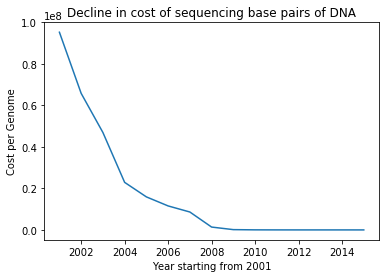

In [395]:
# To do averages, I thought I'd bucketize
# Luckily, years start from 1 and go to 15, so I'll just work with that.
cost_year = np.zeros(len(set(df["Date"])))
data_pts  = np.zeros(len(set(df["Date"])))

# Bucketize data
for i in range(len(df)):
    cost_year[int(df.iloc[i]["Date"]-1)] += df.iloc[i][" Cost per Genome "]
    data_pts[int(df.iloc[i]["Date"]-1)] += 1
    
# Calculate Averages
for i in range(len(cost_year)):
    cost_year[i] /= data_pts[i]
    
# Generate x-axis
years = np.arange(2001, 2016, 1)
plt.plot(years, cost_year)
plt.ylabel("Cost per Genome")
plt.xlabel("Year starting from 2001")
plt.title("Decline in cost of sequencing base pairs of DNA")

Finally, I'll create the deliverable; The Pandas Dataframe!
----

In [398]:
yearly_averages = pd.DataFrame({'Year' : years, 'Average Cost per Genome' : cost_year}, 
                               columns=['Year','Average Cost per Genome'])

yearly_averages

,Year,Average Cost per Genome
0,2001,95263072.00
1,2002,65811929.50
2,2003,46954619.00
3,2004,22916176.00
4,2005,15919004.25
5,2006,11562016.25
6,2007,8632663.75
7,2008,1377846.00
8,2009,141461.75
9,2010,34625.75


Tenderloin Police Department Monthly Crime Report
----

First, we'll start by loading in the data using a pandas dataframe, and extract the for the Tenderloin police department so we can analyze the types of issues in the community are particular hot spots for criminal activity in the region in order to better summarize the landscape of the police academy training program.

In [400]:
# Load in the dataset as a Pandas dataframe.
# Fun fact, Pandas is short for Panel Data as in economics. Cool!
df    = pd.read_csv("sf_crime.csv")               # Reads in the CSV as a dataframe
df    = df[df["PdDistrict"] == "TENDERLOIN"]      # Makes the data frame a dataframe of the subset of PdDistrict; TENDERLOIN.
top_5 = df["Category"].value_counts()[:5]         # Saves the top 5 values in PdDistrict TENDERLOIN's crime categories.
f_10  = df["Category"].value_counts()[5:10]       # Saves the sixth through tenth most common crime categories.
print("\nThe five most common crimes in Tenderloin and frequencies:")
print(top_5)
print("\nThe sixth through tenth most common crimes and frequencies:")
print(f_10)


The five most common crimes in Tenderloin and frequencies:
DRUG/NARCOTIC     186
OTHER OFFENSES    154
LARCENY/THEFT     107
ASSAULT            95
NON-CRIMINAL       79
Name: Category, dtype: int64

The sixth through tenth most common crimes and frequencies:
WARRANTS          78
SUSPICIOUS OCC    35
ROBBERY           25
VANDALISM         21
BURGLARY          18
Name: Category, dtype: int64


Insight:
----
So, we see that DRUG/NARCOTIC, OTHER OFFENSES, LARCENY/THEFT, ASSAULT and NON-CRIMINAL are the most common types of issues that police officers in the Tenderloin district face, so you as a Datascientist make some minor suggestions for the training program.

- For the DRUG/NARCOTIC issue, you suggest greater community outreach and programs to assist individuals in need.
- For the OTHER OFFENSES issue, you suggest a social interaction class emphasizing proper behavior in unknown settings.
- For LARCENY/THEFT, you suggest a instating neighborhood watch programs in troubled areas.
- For ASSAULT, you suggest outreach to local schools identifying assault and what to do in situations involving assault.
- For NON-CRIMINAL, you suggest that that number could be higher, but for good reasons.

Before creating the monthly frequencies, we'll take a peek at the TENDERLOIN dataframe.

In [401]:
# Getting a peek at the dataset before going forward getting monthlies.
print("Peek at the TENDERLOIN Dataframe:")
df[:5]

Peek at the TENDERLOIN Dataframe:


,Year,Month,Time,Time_6am,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
1,2006,5,8.00,2.00,ROBBERY,ROBBERY ON THE STREET WITH A KNIFE,Wednesday,TENDERLOIN,NONE,HYDE ST / OFARRELL ST,-122.416262,37.785375
4,2010,3,15.42,9.42,DRUG/NARCOTIC,SALE OF BASE/ROCK COCAINE,Wednesday,TENDERLOIN,"ARREST, BOOKED",100 Block of EDDY ST,-122.410157,37.784297
8,2010,9,9.90,3.90,SUSPICIOUS OCC,INVESTIGATIVE DETENTION,Friday,TENDERLOIN,NONE,200 Block of HYDE ST,-122.415722,37.783068
18,2010,3,14.58,8.58,OTHER OFFENSES,VIOLATION OF RESTRAINING ORDER,Wednesday,TENDERLOIN,"ARREST, BOOKED",400 Block of ELLIS ST,-122.413631,37.784805
30,2007,9,20.92,14.92,WEAPON LAWS,POSS OF FIREARM BY CONVICTED FELON/ADDICT/ALIEN,Friday,TENDERLOIN,"ARREST, BOOKED",TURK ST / HYDE ST,-122.415695,37.782585


Monthly Frequencies:
----

In [428]:
# Create subsets of the data representative of the categories
# This entirety _could_ be put together for a pandas dataframe
drug      = df[df["Category"] == "DRUG/NARCOTIC" ].groupby(["Year", "Month"])
other     = df[df["Category"] == "OTHER OFFENSES"].groupby(["Year", "Month"])
larceny   = df[df["Category"] == "LARCENY/THEFT" ].groupby(["Year", "Month"])
assault    = df[df["Category"] == "ASSAULT"       ].groupby(["Year", "Month"])
noncrim   = df[df["Category"] == "NON-CRIMINAL"  ].groupby(["Year", "Month"])

Graphing Frequencies:
----

1. DRUG/NARCOTIC Statistics:
----

In [417]:
# Describe the relationship of the data grouped by year and month
drug.mean()[:10]

Time  Time_6am           X          Y
Year Month                                         
2003 2      12.870     6.870 -122.412784  37.782793
     3      17.700    11.700 -122.412090  37.783314
     4      15.520     9.520 -122.414318  37.779944
     5      13.775     7.775 -122.412081  37.781555
     12      9.000     3.000 -122.413070  37.782020
2004 1      12.580     6.580 -122.413048  37.782503
     2      21.000    15.000 -122.416916  37.784394
     3      17.000    11.000 -122.414433  37.784658
     5       2.250    20.250 -122.412224  37.782073
     7      17.450    11.450 -122.413238  37.782843

In [412]:
drug.median()[:10]

Time  Time_6am           X          Y
Year Month                                         
2003 2      12.870     6.870 -122.412784  37.782793
     3      17.700    11.700 -122.412090  37.783314
     4      15.520     9.520 -122.414318  37.779944
     5      13.775     7.775 -122.412081  37.781555
     12      9.000     3.000 -122.413070  37.782020
2004 1      12.580     6.580 -122.413048  37.782503
     2      21.000    15.000 -122.416916  37.784394
     3      17.000    11.000 -122.414433  37.784658
     5       2.250    20.250 -122.412224  37.782073
     7      17.450    11.450 -122.413238  37.782843

In [418]:
drug.std()[:10]

Time  Time_6am         X         Y
Year Month                                        
2003 2      6.168411  6.168411  0.000952  0.001650
     3      8.654987  8.654987  0.000145  0.002417
     4           NaN       NaN       NaN       NaN
     5      1.520280  1.520280  0.003156  0.002434
     12          NaN       NaN       NaN       NaN
2004 1      2.035362  2.035362  0.001628  0.001467
     2           NaN       NaN       NaN       NaN
     3           NaN       NaN       NaN       NaN
     5           NaN       NaN       NaN       NaN
     7           NaN       NaN       NaN       NaN

2. OTHER OFFENSES data
----

In [420]:
other.mean()[:10]

Time   Time_6am           X          Y
Year Month                                             
2003 3      22.250000  16.250000 -122.413640  37.782641
     9      18.940000  12.940000 -122.414107  37.783178
     10     18.000000  12.000000 -122.413238  37.782843
     12      4.270000  22.270000 -122.412883  37.785353
2004 1      22.670000  16.670000 -122.416075  37.784450
     3      12.930000   6.930000 -122.410591  37.784691
     4      14.250000   8.250000 -122.412193  37.781605
     5       5.000000  23.000000 -122.411988  37.785023
     9       1.180000  19.180000 -122.416916  37.784394
     10     18.823333  12.823333 -122.411361  37.784740

In [421]:
other.median()[:10]

Time  Time_6am           X          Y
Year Month                                        
2003 3      22.25     16.25 -122.413640  37.782641
     9      19.25     13.25 -122.415885  37.783516
     10     18.00     12.00 -122.413238  37.782843
     12      4.27     22.27 -122.412883  37.785353
2004 1      22.67     16.67 -122.416075  37.784450
     3      12.93      6.93 -122.410591  37.784691
     4      14.25      8.25 -122.412193  37.781605
     5       5.00     23.00 -122.411988  37.785023
     9       1.18     19.18 -122.416916  37.784394
     10     20.30     14.30 -122.412597  37.783932

In [422]:
other.std()[:10]

Time  Time_6am         X         Y
Year Month                                        
2003 3      0.353553  0.353553  0.003835  0.001467
     9      2.728241  2.728241  0.003079  0.000585
     10          NaN       NaN       NaN       NaN
     12          NaN       NaN       NaN       NaN
2004 1           NaN       NaN       NaN       NaN
     3      4.242641  4.242641  0.001043  0.001846
     4           NaN       NaN       NaN       NaN
     5           NaN       NaN       NaN       NaN
     9           NaN       NaN       NaN       NaN
     10     4.118572  4.118572  0.003659  0.001583

3. LARCENY / THEFT data
----

In [424]:
larceny.mean()[:10]

Time  Time_6am           X          Y
Year Month                                        
2003 3      17.00     11.00 -122.406352  37.786031
     4      13.00      7.00 -122.407067  37.786106
     12     15.58      9.58 -122.407707  37.785103
2004 3      16.50     10.50 -122.414312  37.779834
     4      11.00      5.00 -122.408014  37.785951
     5      16.11     10.11 -122.410715  37.783194
     7      18.58     12.58 -122.407244  37.786565
     8      15.25      9.25 -122.416466  37.780608
     9      18.10     12.10 -122.410536  37.785823
     12     19.00     13.00 -122.417147  37.781446

In [425]:
larceny.median()[:10]

Time  Time_6am           X          Y
Year Month                                        
2003 3      17.00     11.00 -122.406352  37.786031
     4      13.00      7.00 -122.407067  37.786106
     12     15.58      9.58 -122.407707  37.785103
2004 3      16.50     10.50 -122.414312  37.779834
     4      11.00      5.00 -122.408014  37.785951
     5      15.83      9.83 -122.410157  37.784297
     7      18.58     12.58 -122.407244  37.786565
     8      15.25      9.25 -122.416466  37.780608
     9      18.10     12.10 -122.410536  37.785823
     12     19.00     13.00 -122.417147  37.781446

In [426]:
larceny.std()[:10]

Time  Time_6am         X         Y
Year Month                                        
2003 3           NaN       NaN       NaN       NaN
     4      9.899495  9.899495  0.000905  0.001418
     12          NaN       NaN       NaN       NaN
2004 3           NaN       NaN       NaN       NaN
     4           NaN       NaN       NaN       NaN
     5      1.766720  1.766720  0.003781  0.004037
     7           NaN       NaN       NaN       NaN
     8      6.010408  6.010408  0.000165  0.002756
     9      4.101219  4.101219  0.007833  0.001942
     12          NaN       NaN       NaN       NaN

4. ASSAULT data
----

In [430]:
assault.mean()[:10]

Time   Time_6am           X          Y
Year Month                                             
2003 1       9.085000  15.085000 -122.411139  37.785043
     3      20.816667  14.816667 -122.415190  37.783904
     6       6.750000   0.750000 -122.412784  37.784866
     8      13.890000  19.890000 -122.412341  37.784138
     9      16.440000  10.440000 -122.410932  37.785847
     10     19.000000  13.000000 -122.409854  37.783386
     12     11.150000   5.150000 -122.415067  37.783563
2004 6      19.870000  13.870000 -122.412597  37.781119
     7      10.732500   4.732500 -122.412680  37.783660
     8      19.170000  13.170000 -122.410661  37.782707

In [431]:
assault.median()[:10]

Time  Time_6am           X          Y
Year Month                                         
2003 1       9.085    15.085 -122.411139  37.785043
     3      21.980    15.980 -122.415089  37.783672
     6       6.750     0.750 -122.412784  37.784866
     8      13.890    19.890 -122.412341  37.784138
     9      16.440    10.440 -122.410932  37.785847
     10     19.000    13.000 -122.409854  37.783386
     12     11.150     5.150 -122.415067  37.783563
2004 6      19.870    13.870 -122.412597  37.781119
     7       8.795     2.795 -122.414642  37.783411
     8      19.170    13.170 -122.410661  37.782707

In [433]:
assault.std()[:10]

Time  Time_6am         X         Y
Year Month                                         
2003 1      10.019703  6.950860  0.003494  0.000489
     3       2.226035  2.226035  0.000195  0.000499
     6            NaN       NaN       NaN       NaN
     8      14.226988  2.743574  0.004346  0.000479
     9       3.450681  3.450681  0.006370  0.001785
     10           NaN       NaN       NaN       NaN
     12           NaN       NaN       NaN       NaN
2004 6            NaN       NaN       NaN       NaN
     7       5.043044  5.043044  0.005305  0.002708
     8       2.828427  2.828427  0.001970  0.001546

5. NON CRIMINAL data
----

In [434]:
noncrim.mean()[:10]

Time  Time_6am           X          Y
Year Month                                         
2003 3      14.825     8.825 -122.413488  37.783830
     7      11.500     5.500 -122.414433  37.784658
     9       8.000     2.000 -122.412931  37.783834
     10     11.750     5.750 -122.412193  37.781605
2004 2      14.000     8.000 -122.413798  37.785630
     4       5.125    11.125 -122.413260  37.783382
     5      14.500     8.500 -122.410388  37.784464
     8      10.270     4.270 -122.416578  37.780615
     9      10.000     4.000 -122.410928  37.783678
     11      2.800    20.800 -122.413791  37.783837

In [435]:
noncrim.median()[:10]

Time  Time_6am           X          Y
Year Month                                         
2003 3      14.825     8.825 -122.413488  37.783830
     7      11.500     5.500 -122.414433  37.784658
     9       8.000     2.000 -122.412931  37.783834
     10     11.750     5.750 -122.412193  37.781605
2004 2      14.000     8.000 -122.413798  37.785630
     4       5.125    11.125 -122.413260  37.783382
     5      14.500     8.500 -122.410388  37.784464
     8      10.270     4.270 -122.416578  37.780615
     9      10.000     4.000 -122.410928  37.783678
     11      2.800    20.800 -122.413791  37.783837

In [437]:
noncrim.std()[:10]

Time   Time_6am         X         Y
Year Month                                         
2003 3      3.995153   3.995153  0.001032  0.000806
     7           NaN        NaN       NaN       NaN
     9           NaN        NaN       NaN       NaN
     10          NaN        NaN       NaN       NaN
2004 2           NaN        NaN       NaN       NaN
     4      6.540738  10.429825  0.001428  0.001168
     5      3.535534   3.535534  0.003596  0.000891
     8           NaN        NaN       NaN       NaN
     9           NaN        NaN       NaN       NaN
     11          NaN        NaN       NaN       NaN